# Visualize TorNet Classifications

This notebook loads a pretrained model and tests it on TorNet samples

In [1]:
import sys
# Uncomment if tornet isn't installed in your environment or in your path already
#sys.path.append('../')  

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tornet.data.tf.loader import create_tf_dataset 
from tornet.data.constants import ALL_VARIABLES
import tornet.data.preprocess as pp
from tornet.data.tf import preprocess as tfpp

# Load pretrained model
cnn = tf.keras.models.load_model('../models/tornado_detector_baseline.SavedModel',compile=False)

# Can also run
#from tornet.models.tf.cnn_baseline import build_model
#cnn = build_model(c_shape=(120,240,2),start_filters=48,head='maxpool')
#cnn.load_weights('../models/tornado_detector_baseline.SavedModel')


2024-01-25 20:27:38.603662: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 20:27:38.605900: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 20:27:38.650523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 20:27:38.651953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 20:27:39.480766: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Run model on tornado samples

In [3]:
# Create test samples
data_type='test'
years = [2015]

data_root=os.environ['TORNET_ROOT']

catalog_path = os.path.join(data_root,'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at '+data_root)
        
catalog = pd.read_csv(catalog_path,parse_dates=['start_time','end_time'])
catalog = catalog[catalog['type']==data_type]
catalog = catalog[catalog.start_time.dt.year.isin(years)]

# Select EF 3+ tornadoes for testing
catalog=catalog[catalog.ef_number>=2]

catalog = catalog.sample(frac=1,random_state=1234)
file_list = [os.path.join(data_root,f) for f in catalog.filename]

ds_test = create_tf_dataset(file_list,variables=ALL_VARIABLES,n_frames=1) 

# preprocess
ds_test = ds_test.map(lambda d: pp.add_coordinates(d,include_az=False,backend=tf))
ds_test = ds_test.map(pp.remove_time_dim)
ds_test = ds_test.map(tfpp.split_x_y)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)    
ds_test = ds_test.batch(4)

In [4]:
# grab a batch and run through model
for x,y in ds_test:
    p=cnn(x).numpy() # this outputs a logit
    p = 1/(1+np.exp(-p)) # apply sigmoid to map to [0,1]
    break


/state/partition1/llgrid/pkg/anaconda/anaconda3-2023b/lib/python3.9/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['category', 'event_id', 'ef_number', 'az_lower', 'az_upper', 'rng_lower', 'rng_upper', 'time'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


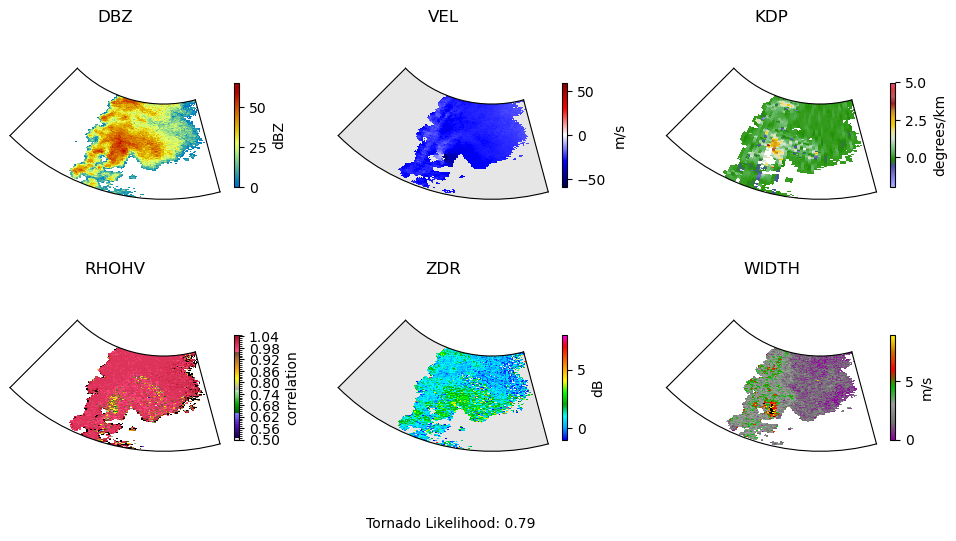

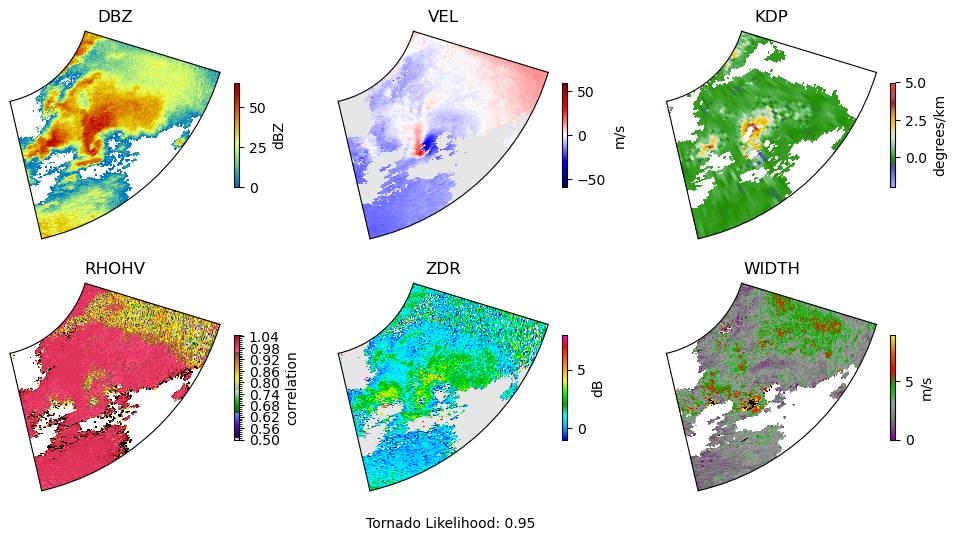

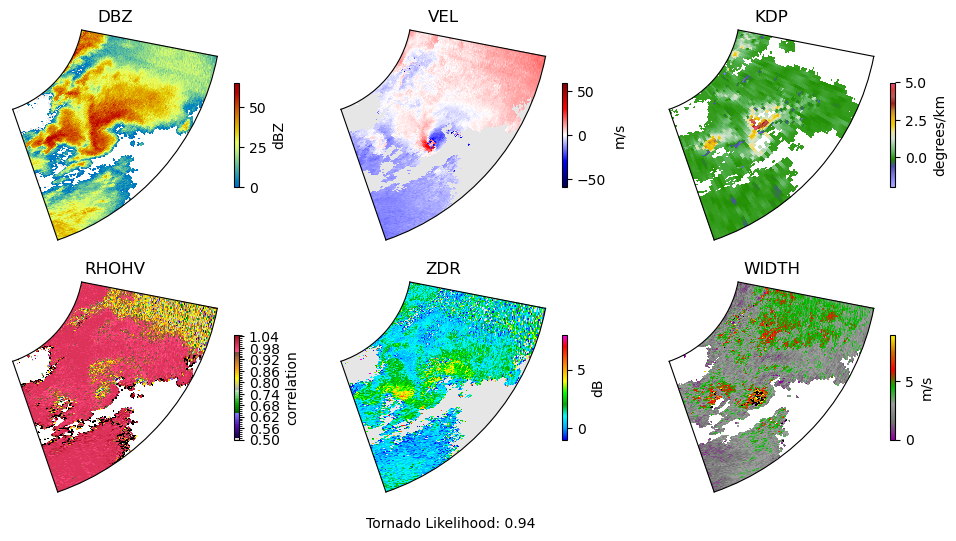

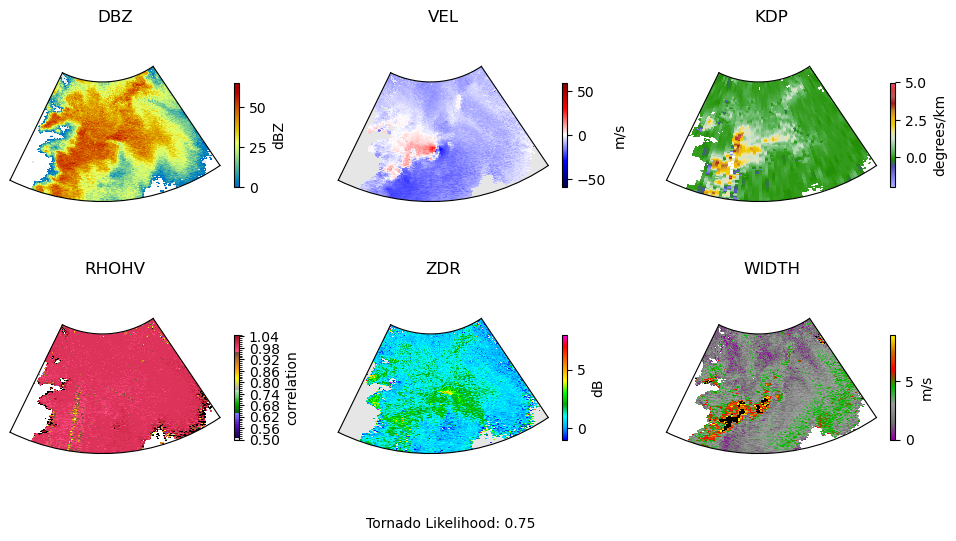

In [5]:
# Visualize samples along with model likelihood
from tornet.display.display import plot_radar

vars_to_plot=['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']

for didx in range(4):
    fig = plt.figure(figsize=(12,6),edgecolor='k')
    plot_radar(x,
               fig=fig,
               channels=vars_to_plot,
               include_cbar=True,
               time_idx=didx, 
               n_rows=2, n_cols=3)

    # Add a caption (optional)
    fig.text(.5, .05, 'Tornado Likelihood: %.2f' % p[didx] , ha='center');
    

## Run model on non-tornado samples

In [118]:
# Create test samples
data_type='test'
years = [2015]

data_root=os.environ['TORNET_ROOT']

catalog_path = os.path.join(data_root,'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at '+data_root)
        
catalog = pd.read_csv(catalog_path,parse_dates=['start_time','end_time'])
catalog = catalog[catalog['type']==data_type]
catalog = catalog[catalog.start_time.dt.year.isin(years)]

# Select EF 3+ tornadoes for testing
catalog=catalog[catalog.ef_number==-1]

catalog = catalog.sample(frac=1,random_state=1234)
file_list = [os.path.join(data_root,f) for f in catalog.filename]

ds_test = create_tf_dataset(file_list,variables=ALL_VARIABLES,n_frames=1) 

# preprocess
ds_test = ds_test.map(lambda d: pp.add_coordinates(d,include_az=False,backend=tf))
ds_test = ds_test.map(pp.remove_time_dim)
ds_test = ds_test.map(tfpp.split_x_y)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)    
ds_test = ds_test.batch(4)

In [120]:
# grab a batch and run through model
for x,y in ds_test:
    p=cnn(x).numpy() # this outputs a logit
    p = 1/(1+np.exp(-p)) # apply sigmoid to map to [0,1]
    break


/state/partition1/llgrid/pkg/anaconda/anaconda3-2023b/lib/python3.9/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['category', 'event_id', 'ef_number', 'az_lower', 'az_upper', 'rng_lower', 'rng_upper', 'time'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


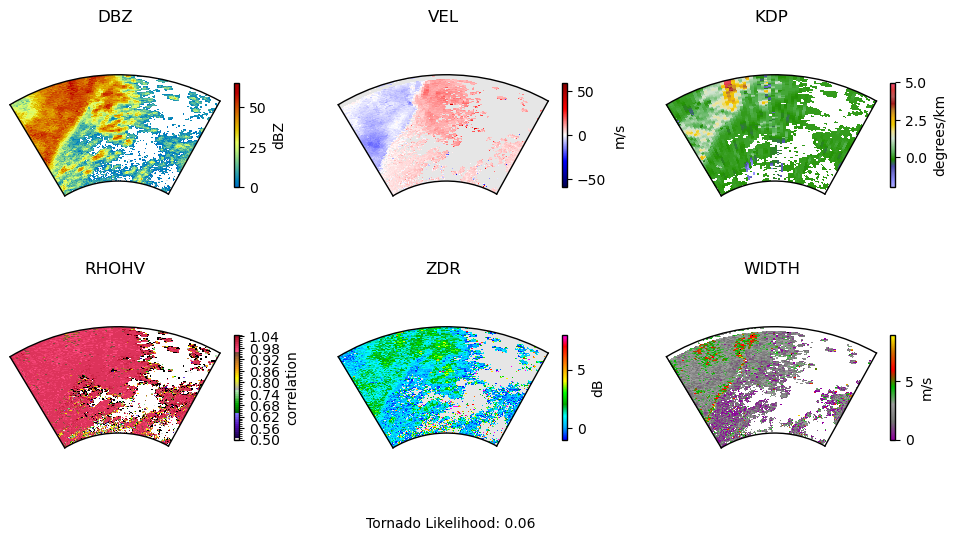

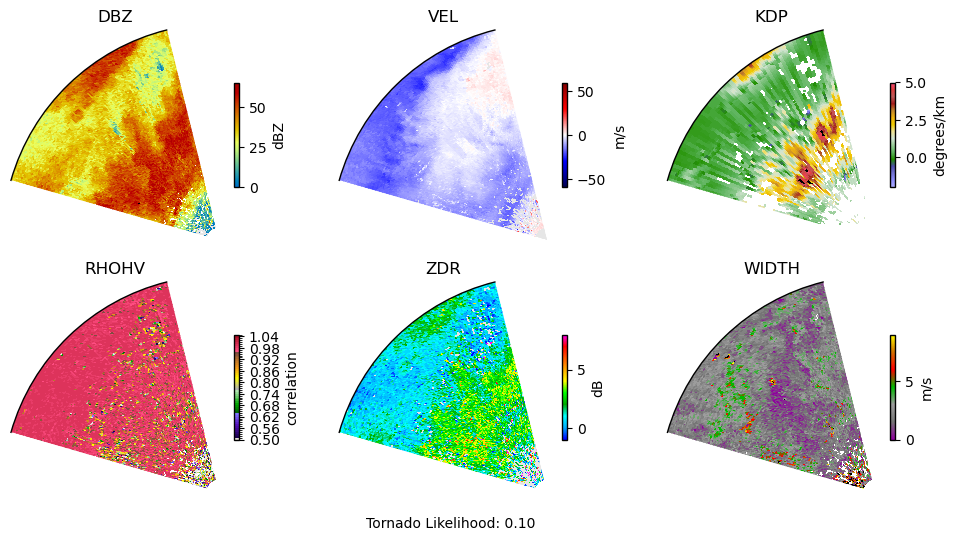

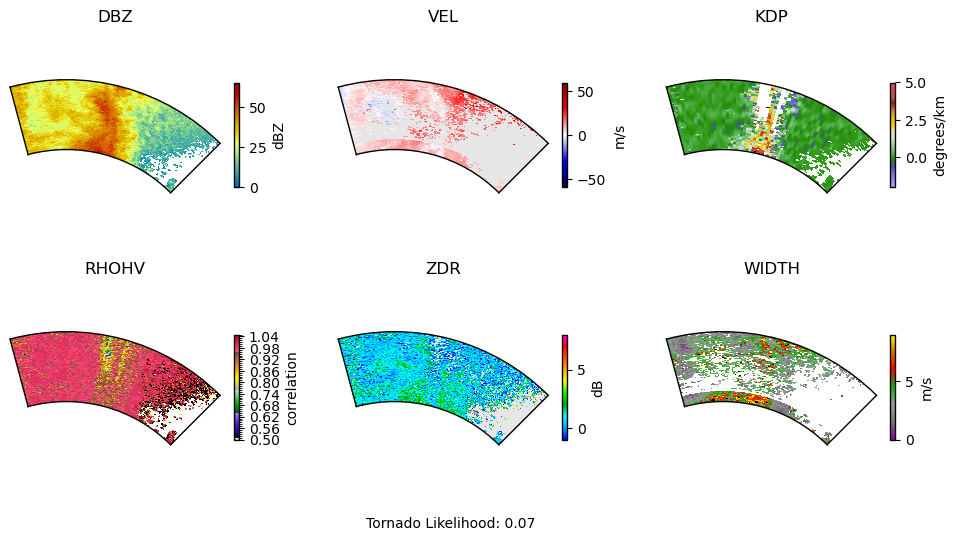

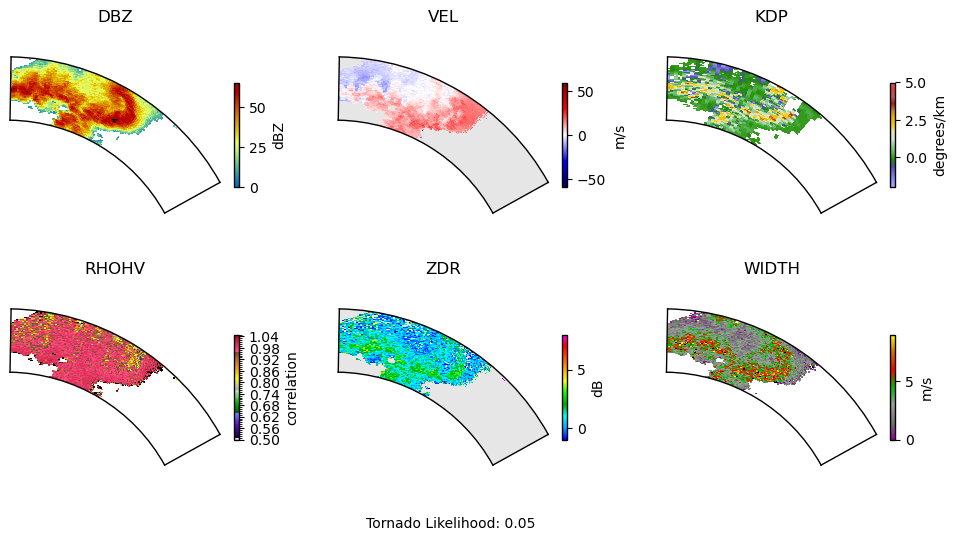

In [121]:
# Visualize samples along with model likelihood
from tornet.display.display import plot_radar

vars_to_plot=['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']

for didx in range(4):
    fig = plt.figure(figsize=(12,6),edgecolor='k')
    plot_radar(x,
               fig=fig,
               channels=vars_to_plot,
               include_cbar=True,
               time_idx=didx, 
               n_rows=2, n_cols=3)

    # Add a caption (optional)
    fig.text(.5, .05, 'Tornado Likelihood: %.2f' % p[didx] , ha='center');
    